# Test Kepler

Notebook that test Kepler construction for 15 minute cities visualizations

## Import modules

In [1]:
import io
import os
import sys

import boto3
import geopandas as gpd
import pandas as pd
from keplergl import KeplerGl

module_path = os.path.abspath(os.path.join("../../"))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(


## Download hexagons with time data

In [2]:
# Creates query to download hex bins

city = 'Victoria'

schema_hex = 'prox_analysis'
table_hex = 'time_15_min_analysis_hexres8'

query = f"SELECT * FROM {schema_hex}.{table_hex} WHERE \"city\" = '{city}'"
hex_gdf = aup.gdf_from_query(query, geometry_col="geometry")

print(hex_gdf.shape)
hex_gdf.head(2)

(125, 30)


,hex_id_8,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,88499b0b59fffff,"POLYGON ((-99.173 23.75856, -99.17768 23.75565...",12.041084,11.246833,6.364854,12.041084,11.296266,11.296266,6.92494,7.951973,...,38.856893,6257.934,3226.7998,3027.3164,1438.20454,1128.74366,3071.41400,613.04000,73.562245,Victoria
1,88499b5695fffff,"POLYGON ((-99.11707 23.7282, -99.11239 23.7311...",10.709240,4.773803,9.861790,10.709240,14.226585,9.238049,5.74918,14.226585,...,29.871049,4438.407,2256.1416,2182.2656,1060.61839,764.66129,2007.39939,605.72815,52.194944,Victoria


In [3]:
hex_gdf['max_idx_15_min'] = hex_gdf[['max_escuelas','max_servicios comunitarios',
                                   'max_comercio','max_entretenimiento']].max(axis=1)

<Axes: >

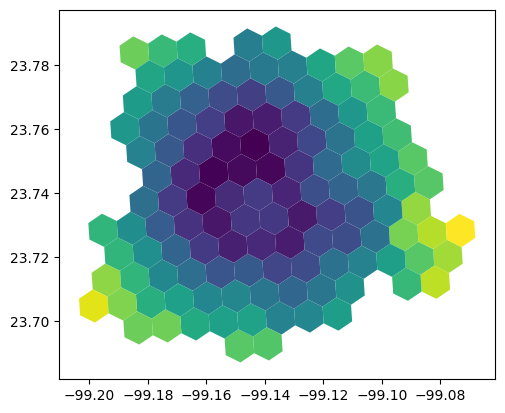

In [4]:
hex_gdf.plot('max_idx_15_min')

## Create Kepler

### Data treatment

In [5]:
columns_kepler = ['max_idx_15_min', 'max_escuelas', 'max_servicios comunitarios',
                      'max_comercio', 'max_entretenimiento','pobtot',
                  'dens_pobha','pobfem','pobmas','pob_0a14',
                      'pob_15a24', 'pob_25a59','p_60ymas']
for c in columns_kepler:
    if c == 'dens_pobha':
        hex_gdf[c] = hex_gdf[c].round(2)
        hex_gdf[c] = hex_gdf[c].astype(str) + ' (pob/ha)'
    else:
        hex_gdf[c] = hex_gdf[c].round().astype(int)
        
        if c != 'max_idx_15_min':
            
            if 'max' in c:
                hex_gdf[c] = hex_gdf[c].astype(str) + ' min'
            else:
                hex_gdf[c] = hex_gdf[c].astype(str)

In [6]:
rename_columns = {'max_escuelas':'Tiempo a escuelas',
                  'max_servicios comunitarios':'Tiempo a servicios comunitarios',
                  'max_comercio':'Tiempo a comercio',
                  'max_entretenimiento':'Tiempo a entretenimiento',
                  'pobtot':'Población total',
                  'dens_pobha':'Densidad de población',
                  'pobfem':'Población femenina',
                  'pobmas':'Población masculina',
                  'pob_0a14':'Población de 0 a 14 años',
                  'pob_15a24':'Población de 15 a 24 años',
                  'pob_25a59':'Población de 25 a 59 años',
                'p_60ymas':'Población de 60 años y más'}

### Missing amenity

In [7]:
lista_amenidades = ['max_preescolar','max_primaria',
                    'max_secundaria','max_salud','max_guarderías',
                    'max_asistencia social','max_alimentos','max_personal',
                    'max_farmacias','max_hogar','max_complementarios','max_social',
                    'max_actividad física', 'max_cultural']

missing_column_name = 'Equipamiento/servicio prioritario'

hex_gdf[missing_column_name] = 'No aplica'

idx = hex_gdf['max_idx_15_min']>15
hex_gdf.loc[idx,missing_column_name] = hex_gdf[lista_amenidades].idxmax(axis=1)

In [8]:
def missing_amenity(amenity_code):
    dict_names = {'max_preescolar':'Preescolar',
                 'max_primaria':'Primaria',
                 'max_secundaria':'Secundaria',
                  'max_guarderías':'Guardería',
                 'max_salud':'Salud - primer contacto',
                 'max_asistencia social':'Centro de asistencia social',
                 'max_alimentos':'Comercio de productos alimenticios',
                 'max_personal':'Comercio para el cuidado personal',
                 'max_farmacias':'Farmacia',
                 'max_hogar':'Comercio de artículos para el hogar',
                 'max_complementario':'Comercio barrial complementario',
                 'max_social':'Espacios de esparcimiento social',
                 'max_actividad física':'Espacios para la actividad física',
                 'max_cultural':'Espacios de esparcimiento cultural',
                 'No aplica':'No aplica'}
    return dict_names[amenity_code]

### Create configuration

In [9]:
column = 'max_idx_15_min'

config,config_idx = aup.kepler_config()

_name = 'Tiempo máximo a todos los servicios'
#_name = 'max_idx_15_min_2'

hex_gdf[_name] = hex_gdf[column].astype(str) + ' min'

bins = [0, 15, 30, 45, 60, hex_gdf[column].max()]
labels = ['0-15', '15-30', '30-45', '45-60', '60>']
hex_gdf[f'bins_{column}'] = pd.cut(
    hex_gdf[column], bins=bins, labels=labels, include_lowest=True)

config_idx["config"]["visState"]["layers"][0]["visualChannels"]["colorField"][
    "name"
] = f'bins_{column}'

config_idx["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
    "Análisis de hexágono"] = [_name, 'Tiempo a escuelas',
                  'Tiempo a servicios comunitarios','Tiempo a comercio',
                  'Tiempo a entretenimiento','           ',
                               'Población total','Densidad de población',
                               'Población femenina','Población masculina',
                               'Población de 0 a 14 años',
                               'Población de 15 a 24 años',
                               'Población de 25 a 59 años',
                               'Población de 60 años y más','            ',
                              missing_column_name]

#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
#    "datos"]= [_name, 'max_escuelas', 'pobtot']

In [10]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['colorRange']['colors']

['#2C51BE', '#7A0DA6', '#CF1750', '#FD7900', '#FAE300']

In [11]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['colorRange']['colors'] = ['#FCD998','#F9A56A','#EC5F8F','#8B3569','#242258']

In [12]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['opacity']

0.35

In [13]:
config_idx['config']['visState']['layers'][0]['config']['visConfig']['opacity'] = 0.35

In [14]:
hex_kepler = hex_gdf[[_name, 'max_escuelas', 'max_servicios comunitarios',
                      'max_comercio', 'max_entretenimiento','pobtot',
                      'dens_pobha','pobfem','pobmas','pob_0a14',
                      'pob_15a24', 'pob_25a59','p_60ymas',missing_column_name,
                      'geometry',f'bins_{column}']] # .copy().to_json()

In [15]:
for c in rename_columns.keys():
    hex_kepler.rename(columns={c : rename_columns[c]}, inplace=True)

/tmp/ipykernel_35022/1188379886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_kepler.rename(columns={c : rename_columns[c]}, inplace=True)


In [35]:
hex_kepler[missing_column_name] = hex_kepler[missing_column_name].apply(missing_amenity)

/home/edgaregurrola/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
hex_kepler['           '] = '         '
hex_kepler['            '] = '          '

/home/edgaregurrola/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/edgaregurrola/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
hex_kepler.head(4)

,Tiempo máximo a todos los servicios,Tiempo a escuelas,Tiempo a servicios comunitarios,Tiempo a comercio,Tiempo a entretenimiento,Población total,Densidad de población,Población femenina,Población masculina,Población de 0 a 14 años,Población de 15 a 24 años,Población de 25 a 59 años,Población de 60 años y más,Equipamiento/servicio prioritario,geometry,bins_max_idx_15_min,,
0,123 min,11 min,24 min,8 min,123 min,1030,12.53 (pob/ha),539,491,222,176,479,153,Espacios de esparcimiento cultural,"POLYGON ((-96.82429 17.24028, -96.81985 17.243...",60>,,
1,100 min,29 min,18 min,20 min,100 min,201,2.45 (pob/ha),102,99,50,36,95,21,Espacios de esparcimiento cultural,"POLYGON ((-96.81071 17.24378, -96.81515 17.240...",60>,,
2,112 min,18 min,14 min,8 min,112 min,1444,17.57 (pob/ha),757,688,298,244,675,227,Espacios de esparcimiento cultural,"POLYGON ((-96.82429 17.24028, -96.82404 17.235...",60>,,
3,112 min,112 min,20 min,20 min,20 min,65,0.8 (pob/ha),37,28,13,8,33,11,Secundaria,"POLYGON ((-96.80447 17.21114, -96.80003 17.214...",60>,,


In [38]:
# hex_gdf["d"] = 0
longitude = hex_gdf.dissolve().geometry.centroid.x
latitude = hex_gdf.dissolve().geometry.centroid.y
config_idx["config"]["mapState"]["latitude"] = latitude[0]
config_idx["config"]["mapState"]["longitude"] = longitude[0]
# session = boto3.Session(profile_name="observatorio")
# dev_s3_client = session.client("s3")
# map_city = KeplerGl(height=800, data={"Análisis de ciudad": hex_kepler}, config=config_idx)
map_city = KeplerGl(height=800)
map_city.config = config_idx
map_city.add_data(hex_kepler, name='Análisis de hexágono')
map_city.save_to_html(file_name=f"{city.lower()}.html", read_only=True)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to oaxaca.html!


/tmp/ipykernel_25542/481004030.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_gdf.dissolve().geometry.centroid.x
/tmp/ipykernel_25542/481004030.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_gdf.dissolve().geometry.centroid.y
